In [34]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load datasets
DATASET_DIRECTORY = 'dataset'
train_df = pd.read_csv(os.path.join(DATASET_DIRECTORY, "train.csv"))
test_df = pd.read_csv(os.path.join(DATASET_DIRECTORY, "test.csv"))
result_df = pd.read_csv(os.path.join(DATASET_DIRECTORY, "result.csv"))

print("\nData Summary:")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Result shape: {result_df.shape}")


Data Summary:
Train shape: (5800, 27)
Test shape: (1200, 26)
Result shape: (1200, 2)


In [3]:
# Create copies of the datasets
train_cleaned = train_df.copy()
test_cleaned = test_df.copy()
result_cleaned = result_df.copy()

In [4]:
# Function to clean the dataset
def clean_data(df):
    # 1. Handling Missing Values
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].fillna(df[column].mode().iloc[0])
        else:
            df[column] = df[column].fillna(df[column].mean())

    # 2. Removing Duplicate Rows
    df.drop_duplicates(inplace=True)

    # 3. Handling Outliers (Using IQR method)
    numeric_cols = df.select_dtypes(include=['number']).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

    # 4. Dropping Unnecessary Columns (if applicable)
    id_columns = ['Interview Id', 'Candidate Id', 'Interviewer Id']
    df.drop(columns=id_columns, errors='ignore', inplace=True)

    # 5. Check for columns with a single unique value
    unique_counts = df.nunique()
    cols_to_drop = unique_counts[unique_counts == 1].index
    df.drop(columns=cols_to_drop, inplace=True)

    # 6. Standardizing Text Format (Lowercase, Stripping Spaces)
    df = df.apply(lambda col: col.str.strip().str.lower() if col.dtype == "object" else col)
    return df

# Apply cleaning functions
train_cleaned = clean_data(train_cleaned)
test_cleaned = clean_data(test_cleaned)
result_cleaned = clean_data(result_cleaned)

# Check dataset information after cleaning
train_cleaned.info(), test_cleaned.info(), result_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800 entries, 0 to 5799
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Profile             5800 non-null   object 
 1   S.L.R.C             5800 non-null   float64
 2   S.L.R.I             5800 non-null   float64
 3   A.T.T               5800 non-null   int64  
 4   L.M.I               5800 non-null   int64  
 5   L.M.C               5800 non-null   int64  
 6   S.R                 5800 non-null   int64  
 7   L.J.T.C             5800 non-null   int64  
 8   L.J.T.I             5800 non-null   int64  
 9   N.I.C               5800 non-null   int64  
 10  N.I.I               5800 non-null   int64  
 11  S.P.I               5800 non-null   int64  
 12  S.P.C               5800 non-null   int64  
 13  L.A.C               5800 non-null   int64  
 14  L.A.I               5800 non-null   int64  
 15  Q.A                 5800 non-null   int64  
 16  P.E.I 

(None, None, None)

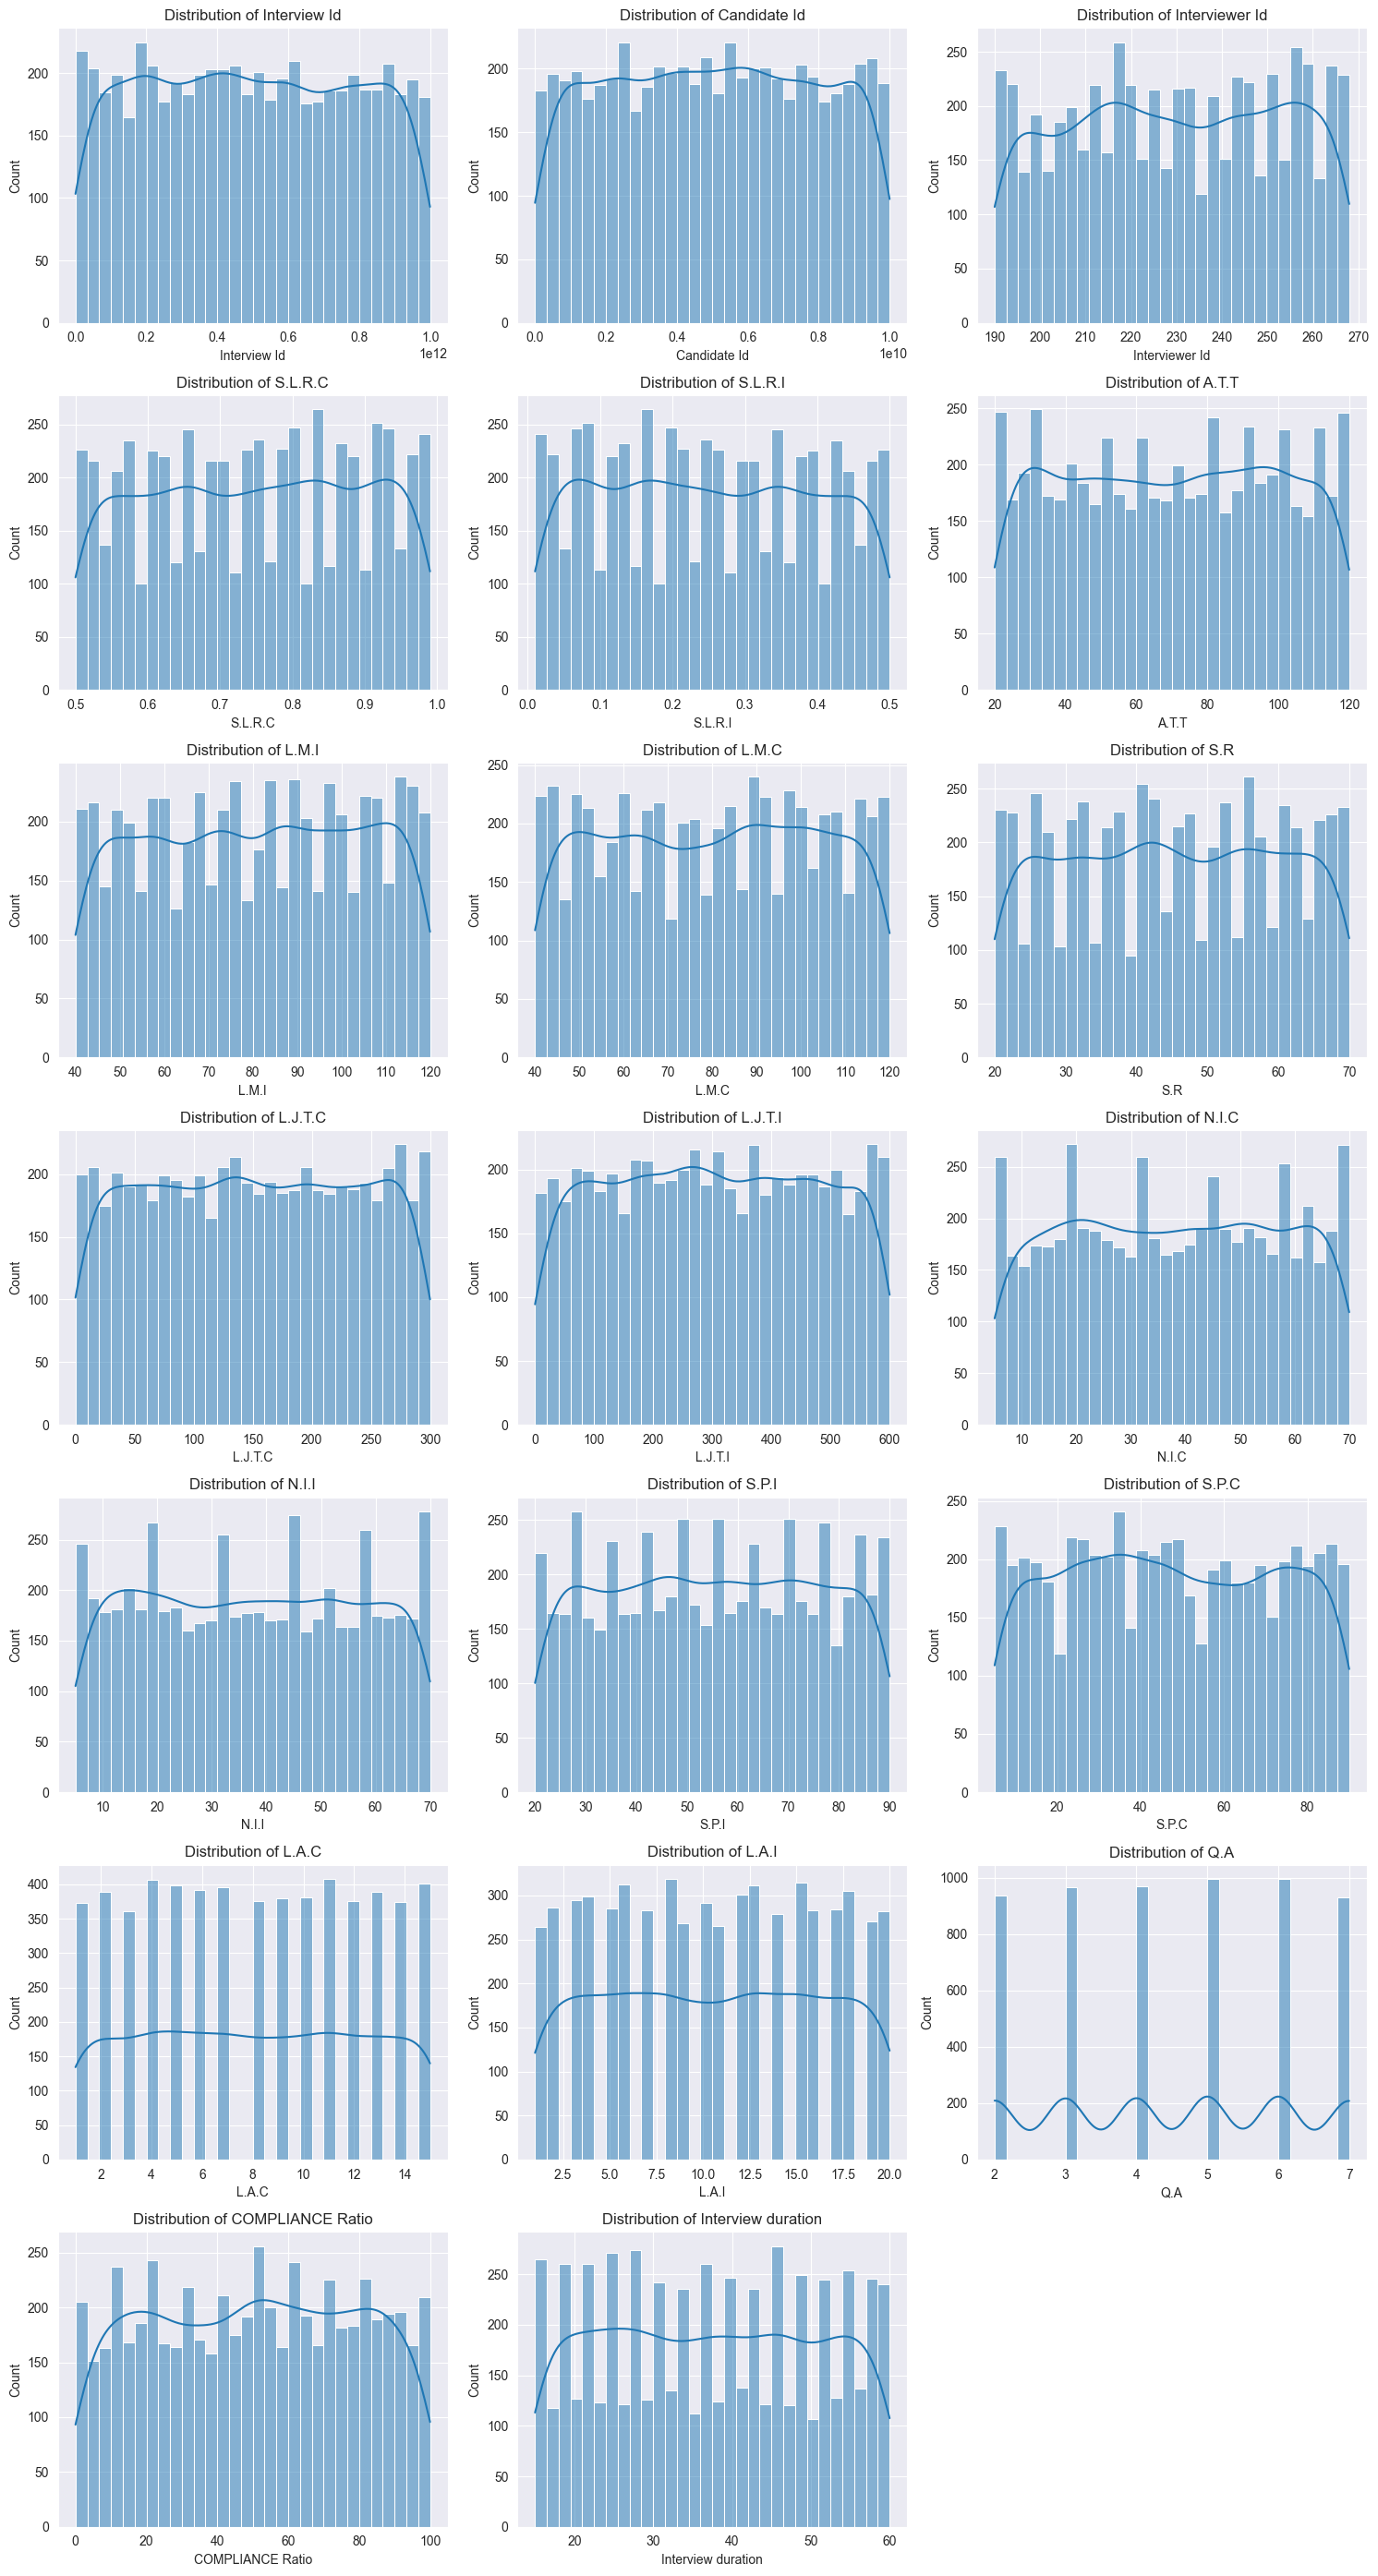

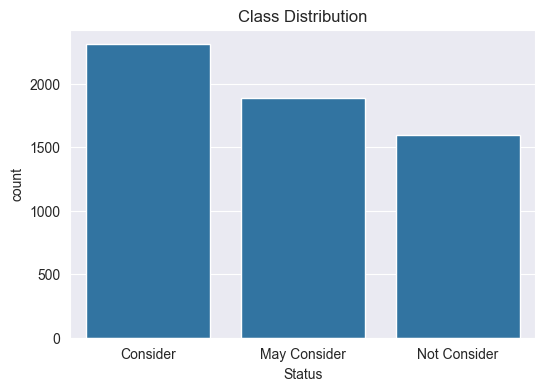

In [5]:
# Select all numerical columns
numerical_cols = train_df.select_dtypes(include=['number']).columns

# Set up the number of rows and columns for subplots
num_features = len(numerical_cols)
num_cols = 3  # Number of columns per row
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)  # Calculate required rows

# Create subplots
plt.figure(figsize=(15, num_rows * 4))  # Adjust figure size
for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Checking class balance (if applicable)
if 'Status' in train_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=train_df['Status'])
    plt.title("Class Distribution")
    plt.show()

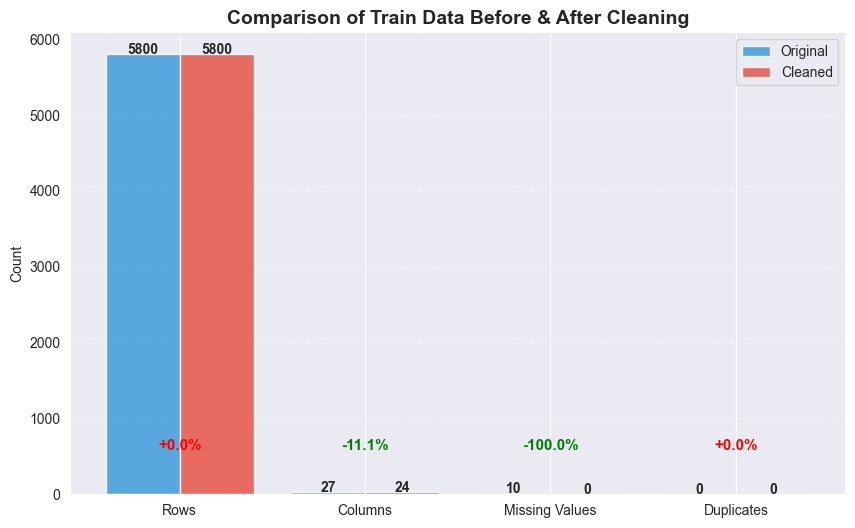

           Metric  Original  Cleaned  Change (%)
0            Rows      5800     5800        0.00
1         Columns        27       24      -11.11
2  Missing Values        10        0     -100.00
3      Duplicates         0        0        0.00


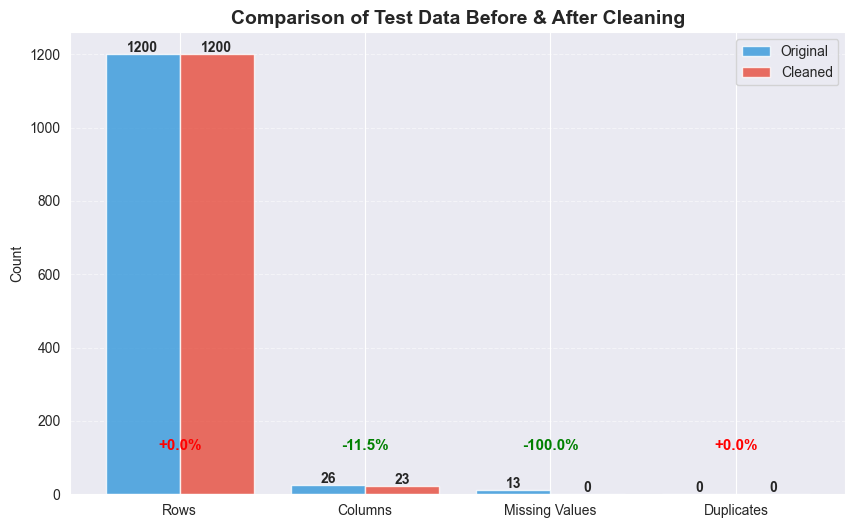

           Metric  Original  Cleaned  Change (%)
0            Rows      1200     1200        0.00
1         Columns        26       23      -11.54
2  Missing Values        13        0     -100.00
3      Duplicates         0        0        0.00


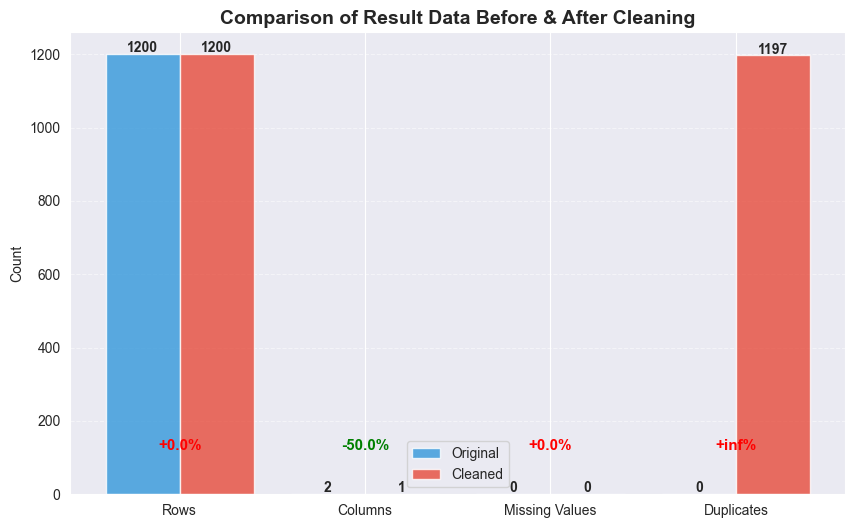

           Metric  Original  Cleaned  Change (%)
0            Rows      1200     1200         0.0
1         Columns         2        1       -50.0
2  Missing Values         0        0         0.0
3      Duplicates         0     1197         inf


In [6]:
def compare_datasets(original_df, cleaned_df, dataset_name="Dataset"):
    """Compare original and cleaned datasets and visualize the differences."""

    # Calculate statistics before and after cleaning
    metrics = ["Rows", "Columns", "Missing Values", "Duplicates"]
    original_values = [
        original_df.shape[0],
        original_df.shape[1],
        original_df.isnull().sum().sum(),
        original_df.duplicated().sum()
    ]

    cleaned_values = [
        cleaned_df.shape[0],
        cleaned_df.shape[1],
        cleaned_df.isnull().sum().sum(),
        cleaned_df.duplicated().sum()
    ]

    # Create DataFrame for comparison
    compare_df = pd.DataFrame({
        "Metric": metrics,
        "Original": original_values,
        "Cleaned": cleaned_values
    })

    # Calculate percentage change
    compare_df["Change (%)"] = ((compare_df["Cleaned"] - compare_df["Original"]) / compare_df["Original"]) * 100
    compare_df["Change (%)"] = compare_df["Change (%)"].fillna(0).round(2)  # Handle division by zero

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.4  # Bar width

    bars1 = ax.bar(x - width/2, compare_df["Original"], width, label="Original", color="#3498db", alpha=0.8)
    bars2 = ax.bar(x + width/2, compare_df["Cleaned"], width, label="Cleaned", color="#e74c3c", alpha=0.8)

    # Add labels on bars
    for bar in bars1 + bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha="center", fontsize=10, fontweight="bold")

    # Add percentage change annotations
    for i, change in enumerate(compare_df["Change (%)"]):
        color = "green" if change < 0 else "red"
        ax.text(x[i], max(compare_df["Original"].max(), compare_df["Cleaned"].max()) * 0.1,
                f"{change:+.1f}%", ha="center", fontsize=11, color=color, fontweight="bold")

    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylabel("Count")
    ax.set_title(f"Comparison of {dataset_name} Before & After Cleaning", fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    plt.show()

    # Print comparison table
    print(compare_df)

# Apply function to visualize train, test, and result datasets
compare_datasets(train_df, train_cleaned, "Train Data")
compare_datasets(test_df, test_cleaned, "Test Data")
compare_datasets(result_df, result_cleaned, "Result Data")

In [15]:
def label_encode(df, encoders=None):
    """Apply Label Encoding to categorical columns with consistent encoding."""
    df = df.copy()  # Avoid modifying original
    if encoders is None:
        encoders = {}

    for col in df.select_dtypes(include=['object']).columns:
        if col not in encoders:  # If encoder doesn't exist, create a new one
            encoders[col] = LabelEncoder()
            df[col] = encoders[col].fit_transform(df[col])
        else:
            df[col] = df[col].map(lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1)

    return df, encoders

# Apply Label Encoding (Ensure Consistency)
train_encoded, label_encoders = label_encode(train_cleaned)  # Train first
test_encoded, _ = label_encode(test_cleaned, label_encoders)  # Use same encoders
result_encoded, _ = label_encode(result_cleaned, label_encoders)  # Use same encoders

# Check result
print(train_encoded.head())
print(test_encoded.head())
print(result_encoded.head())

   Profile  S.L.R.C  S.L.R.I  A.T.T  L.M.I  L.M.C  S.R  L.J.T.C  L.J.T.I  \
0        2     0.98     0.02     53     88     93   32       88      106   
1        9     0.67     0.33     51     53     44   36       93      313   
2        6     0.81     0.19     60     77     75   54       52       67   
3        4     0.69     0.31     93     42    103   49      115      166   
4        7     0.57     0.43     44     44    119   66      190      394   

   N.I.C  ...  L.A.I  Q.A  P.E.I  P.E.C  COMPLIANCE Ratio  Interview duration  \
0     41  ...     15    6      1      1                98                  37   
1     28  ...     15    4      1      0                54                  33   
2     26  ...      7    3      2      2                31                  58   
3     62  ...     10    7      2      0                24                  35   
4      7  ...      7    3      0      2                73                  60   

   Interviewer Intro  Candidate into  Opp to ask  Status

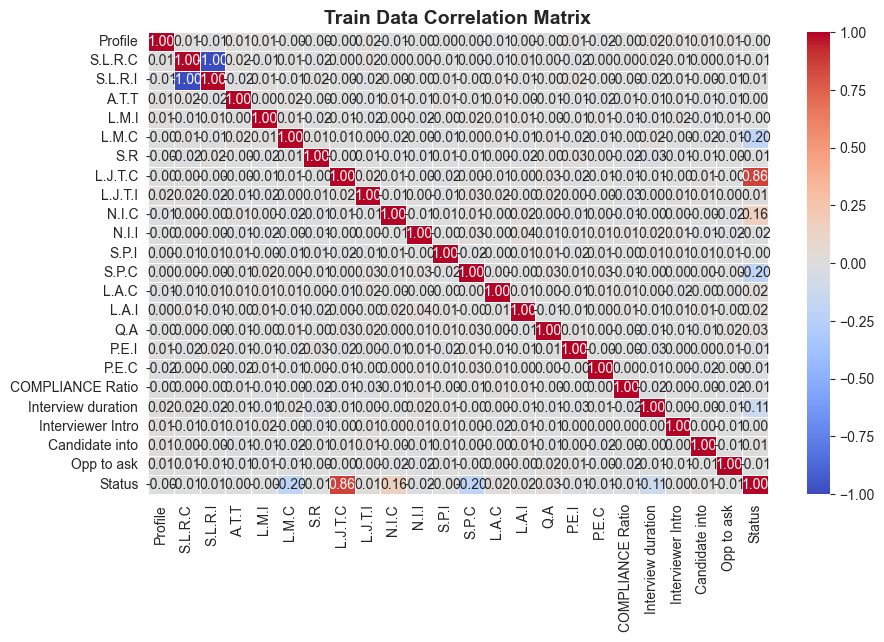

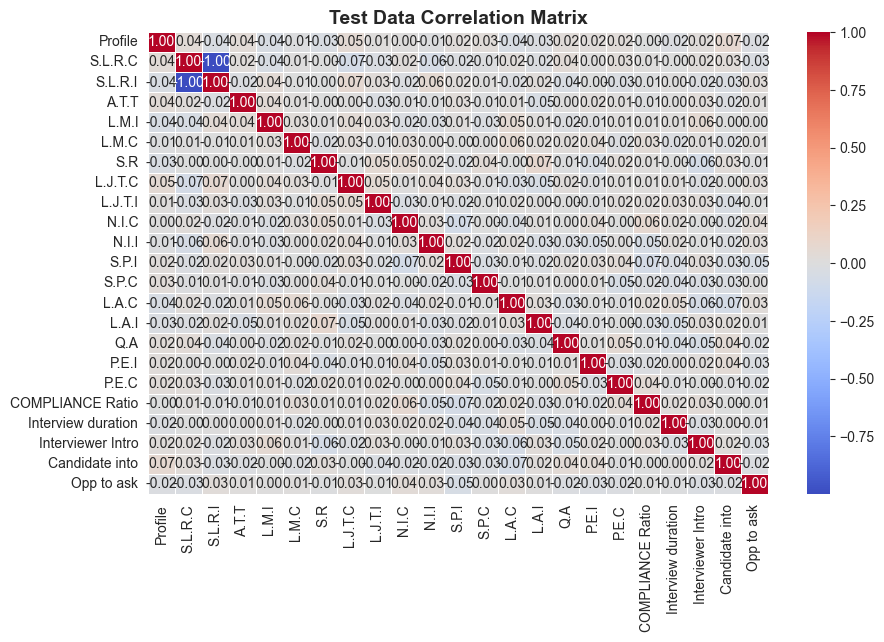

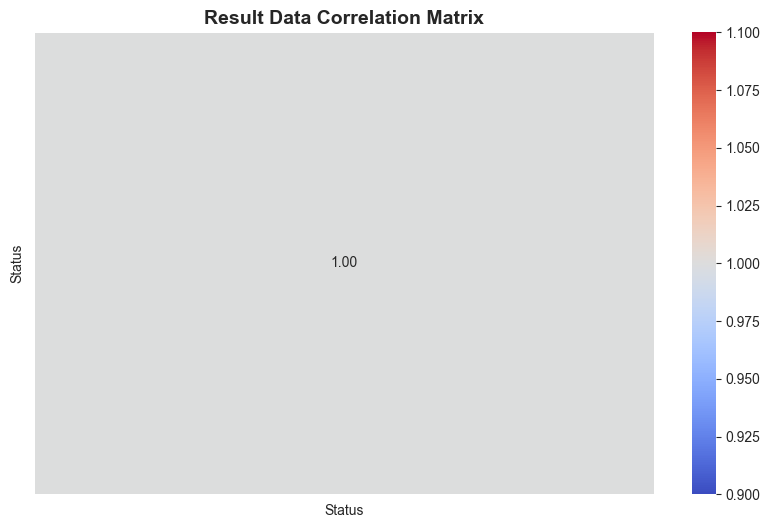

In [16]:
def plot_correlation_matrix(df, title="Correlation Matrix"):
    """Plot the correlation matrix of a DataFrame."""
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.show()

# Plot Correlation Matrices
plot_correlation_matrix(train_encoded, "Train Data Correlation Matrix")
plot_correlation_matrix(test_encoded, "Test Data Correlation Matrix")
plot_correlation_matrix(result_encoded, "Result Data Correlation Matrix")

Feature Correlation with Status:
 Status                1.000000
L.J.T.C               0.855209
S.P.C                 0.202820
L.M.C                 0.195382
N.I.C                 0.156023
Interview duration    0.113541
Q.A                   0.026191
L.A.C                 0.020605
L.A.I                 0.015609
N.I.I                 0.015491
P.E.C                 0.013091
L.J.T.I               0.012643
P.E.I                 0.009758
COMPLIANCE Ratio      0.009549
Candidate into        0.009148
S.L.R.I               0.007200
S.L.R.C               0.007200
Opp to ask            0.005970
S.R                   0.005600
S.P.I                 0.004676
Profile               0.003021
Interviewer Intro     0.001916
L.M.I                 0.000412
A.T.T                 0.000366
Name: Status, dtype: float64
Selected Features (Correlation Method): ['L.J.T.C', 'S.P.C']
Feature Importance (Random Forest):
 L.J.T.C               0.491213
S.P.C                 0.058915
L.M.C                 0.056424
N.

<Figure size 1400x600 with 0 Axes>

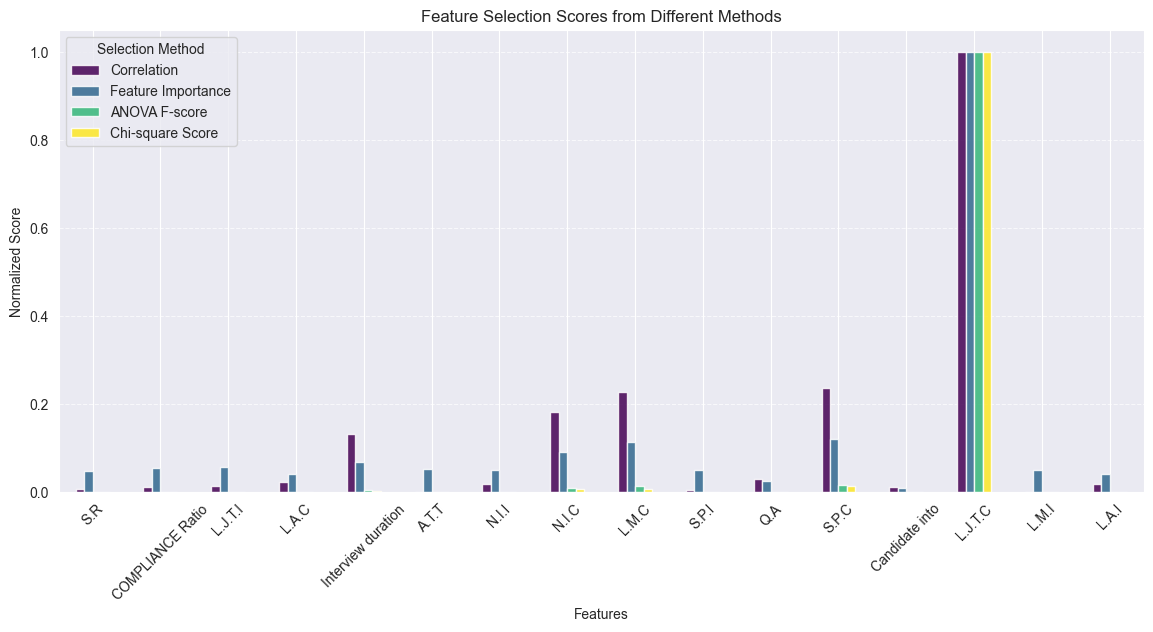

In [38]:
# Define the target column
TARGET_COLUMN = "Status"

# Ensure 'Status' exists and is numerical
if TARGET_COLUMN in train_encoded.columns:
    train_encoded[TARGET_COLUMN] = train_encoded[TARGET_COLUMN].astype("category").cat.codes

# 1. Compute Correlation with Target
correlation = train_encoded.corr()[TARGET_COLUMN].abs().sort_values(ascending=False)
print("Feature Correlation with Status:\n", correlation)

# Select highly correlated features (e.g., correlation > 0.2)
selected_features = correlation[correlation > 0.2].index.tolist()
selected_features.remove(TARGET_COLUMN)  # Remove target column
print("Selected Features (Correlation Method):", selected_features)

# Separate Features (X) and Target (y)
X = train_encoded.drop(columns=[TARGET_COLUMN])  # Features
y = train_encoded[TARGET_COLUMN]  # Target

# 2. Feature Importance using RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance (Random Forest):\n", feature_importance)

# Select top N features (e.g., top 10)
top_n_features = feature_importances.nlargest(10).index.tolist()
print("Top Features (Random Forest Method):", top_n_features)


# 3. Select Top Features (Using ANOVA F-score)
anova_selector = SelectKBest(score_func=f_classif, k=min(10, len(X.columns)))
anova_selector.fit(X, y)
anova_scores = pd.Series(anova_selector.scores_, index=X.columns).sort_values(ascending=False)


# Select categorical features only (assuming they are encoded as integers)
categorical_features = X.select_dtypes(include=['int', 'category']).columns
X_categorical = X[categorical_features]

# 4. Chi-square Test for Categorical Features
chi2_selector = SelectKBest(chi2, k=min(10, len(X_categorical.columns)))
chi2_selector.fit(X_categorical, y)

# Store feature scores and select top features
chi2_scores = pd.Series(chi2_selector.scores_, index=categorical_features).sort_values(ascending=False)
top_chi2_features = chi2_scores.index.tolist()

print("Top Features (Chi-square Method):", top_chi2_features)

# 5. Combine Top Features from All Methods
num_features = 10
selected_features = list(set(correlation.index[:num_features]) |
                         set(feature_importances.index[:num_features]) |
                         set(anova_scores.index[:num_features]) |
                         set(chi2_scores.index[:num_features]))


# 6. Visualization of Selected Features
# Remove 'Status' if it's mistakenly included
selected_features = [feat for feat in selected_features if feat != 'Status']

# Create a DataFrame with all feature selection scores
feature_scores = pd.DataFrame({
    'Correlation': correlation[selected_features],
    'Feature Importance': feature_importances[selected_features],
    'ANOVA F-score': anova_scores[selected_features],
    'Chi-square Score': chi2_scores[selected_features]
}).fillna(0)  # Fill NaNs if any feature is missing in some methods

# Normalize scores for better comparison
feature_scores = feature_scores / feature_scores.max()

# Plot the comparison of feature selection methods
plt.figure(figsize=(14, 6))
feature_scores.plot(kind='bar', figsize=(14, 6), colormap="viridis", alpha=0.85)

plt.xlabel("Features")
plt.ylabel("Normalized Score")
plt.title("Feature Selection Scores from Different Methods")
plt.legend(title="Selection Method")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 7. Filter Dataset with Selected Features
# train_selected = train_encoded[selected_features + [TARGET_COLUMN]]
# test_selected = test_encoded[selected_features]
# result_selected = result_encoded[selected_features]
#
# print("Selected Features:", selected_features)

Decision Tree Accuracy: 0.8603
Random Forest Accuracy: 0.9060
AdaBoost Accuracy: 0.8802
Gradient Boosting Accuracy: 0.9405
Naïve Bayes Accuracy: 0.8319
KNN Accuracy: 0.8526


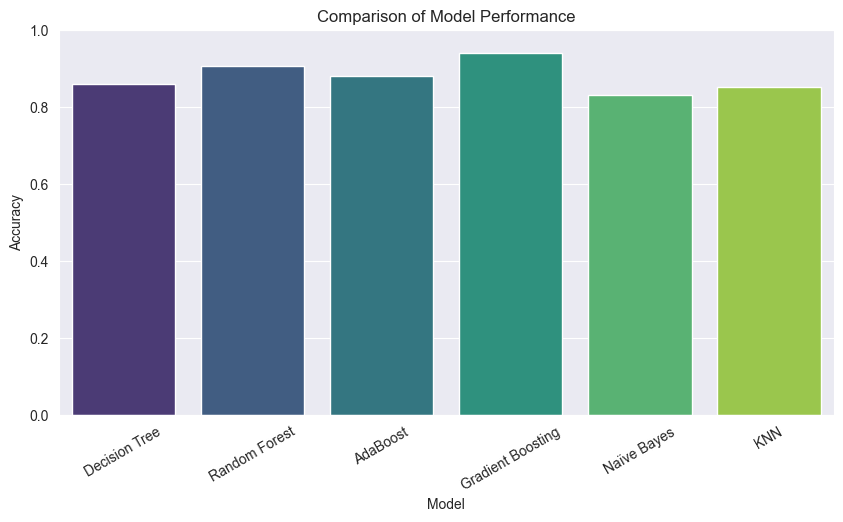

In [36]:
# Define features (X) and target (y)
X = train_encoded.drop(columns=["Status"])  # Features
y = train_encoded["Status"]  # Target

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Naïve Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5)  # Default k=5
}

# Train and evaluate each model
model_accuracies = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on test set
    acc = accuracy_score(y_test, y_pred)  # Compute accuracy
    model_accuracies[name] = acc  # Store accuracy
    print(f"{name} Accuracy: {acc:.4f}")

# Plot accuracies
plt.figure(figsize=(10, 5))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), hue=list(model_accuracies.keys()), palette="viridis", legend=False)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Performance")
plt.xticks(rotation=30)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()

Decision Tree: DecisionTreeClassifier(random_state=42)
✅ Accuracy: 0.8603
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       503
           1       0.76      0.78      0.77       345
           2       0.87      0.88      0.88       312

    accuracy                           0.86      1160
   macro avg       0.85      0.85      0.85      1160
weighted avg       0.86      0.86      0.86      1160



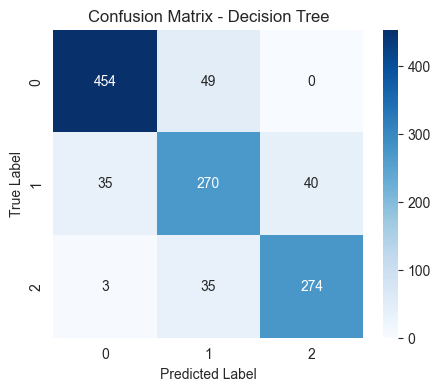

Random Forest: RandomForestClassifier(random_state=42)
✅ Accuracy: 0.9060
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       503
           1       0.84      0.84      0.84       345
           2       0.90      0.93      0.91       312

    accuracy                           0.91      1160
   macro avg       0.90      0.90      0.90      1160
weighted avg       0.91      0.91      0.91      1160



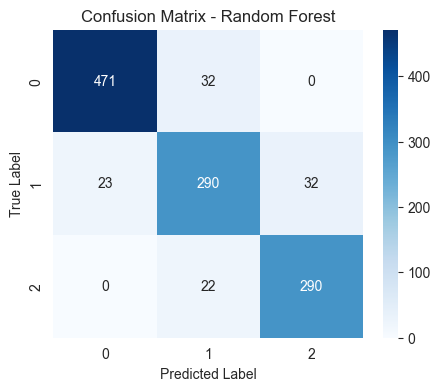

AdaBoost: AdaBoostClassifier(n_estimators=100, random_state=42)
✅ Accuracy: 0.8802
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.93       503
           1       0.74      0.93      0.82       345
           2       0.96      0.82      0.88       312

    accuracy                           0.88      1160
   macro avg       0.89      0.88      0.88      1160
weighted avg       0.90      0.88      0.88      1160



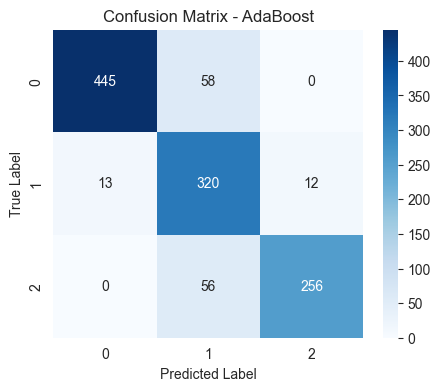

Gradient Boosting: GradientBoostingClassifier(random_state=42)
✅ Accuracy: 0.9405
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       503
           1       0.89      0.91      0.90       345
           2       0.94      0.96      0.95       312

    accuracy                           0.94      1160
   macro avg       0.94      0.94      0.94      1160
weighted avg       0.94      0.94      0.94      1160



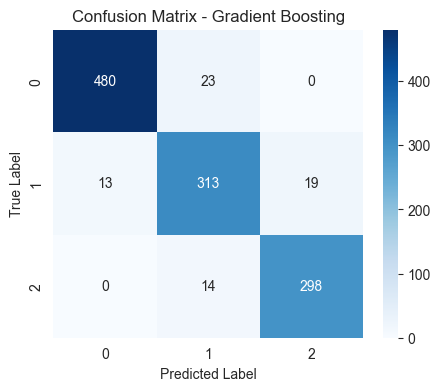

Naïve Bayes: GaussianNB()
✅ Accuracy: 0.8319
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       503
           1       0.71      0.73      0.72       345
           2       0.83      0.87      0.85       312

    accuracy                           0.83      1160
   macro avg       0.82      0.83      0.82      1160
weighted avg       0.83      0.83      0.83      1160



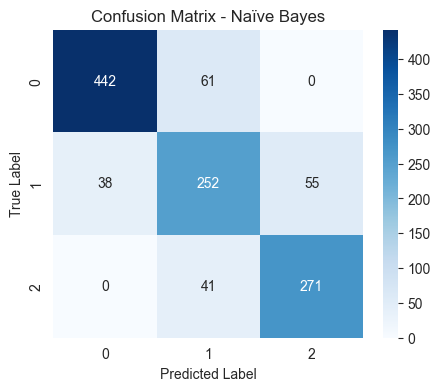

KNN: KNeighborsClassifier()
✅ Accuracy: 0.8526
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       503
           1       0.75      0.77      0.76       345
           2       0.86      0.87      0.87       312

    accuracy                           0.85      1160
   macro avg       0.84      0.85      0.84      1160
weighted avg       0.85      0.85      0.85      1160



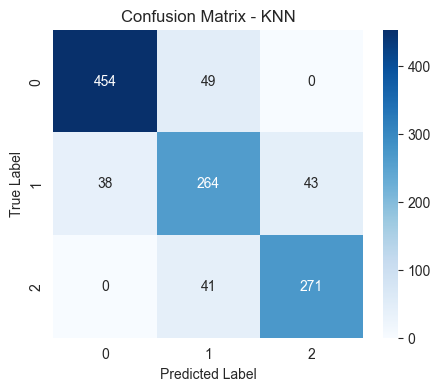

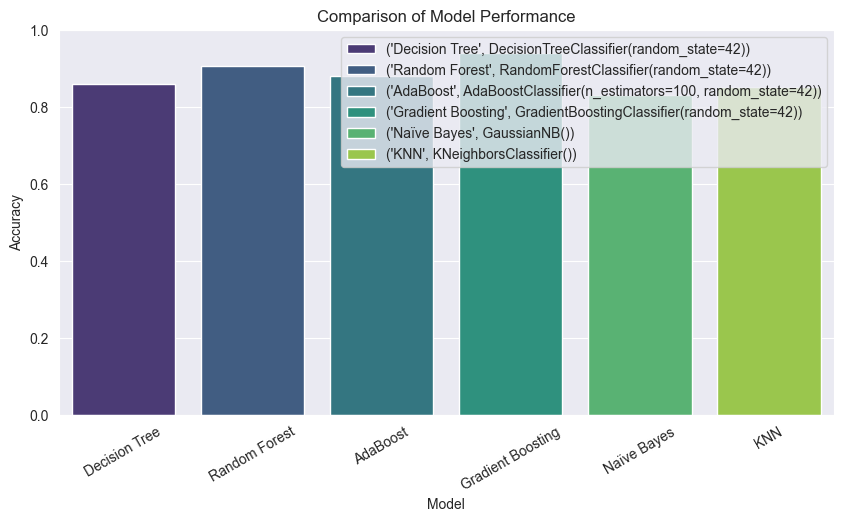

In [42]:
# List of trained models (assuming they're already fitted)
models = {
    "Decision Tree": models["Decision Tree"],  # Trained Decision Tree model
    "Random Forest": models["Random Forest"],  # Trained Random Forest model
    "AdaBoost": models["AdaBoost"],  # Trained AdaBoost model
    "Gradient Boosting": models["Gradient Boosting"],  # Trained Gradient Boosting model
    "Naïve Bayes": models["Naïve Bayes"],  # Trained Naïve Bayes model
    "KNN": models["KNN"]  # Trained K-Nearest Neighbors model
}

# Initialize a dictionary to store model evaluation metrics
model_metrics = {}

# Iterate through models and evaluate them
for name, model in models.items():
    # Predictions
    y_pred = model.predict(X_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store in dictionary
    model_metrics[name] = {
        "Accuracy": accuracy,
        "Classification Report": report,
        "Confusion Matrix": conf_matrix
    }

    # Print evaluation results
    print(f"{name}: {model}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print("🔹 Classification Report:\n", report)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Compare accuracy scores
plt.figure(figsize=(10, 5))
sns.barplot(x=list(model_metrics.keys()), y=[m["Accuracy"] for m in model_metrics.values()], hue=models.items(), palette="viridis")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Performance")
plt.xticks(rotation=30)
plt.ylim(0, 1)  # Accuracy between 0 and 1
plt.show()

In [44]:
# Define hyperparameter grids
param_grids = {
    "Decision Tree": {
        "max_depth": [3, 5, 10, None],
        "criterion": ["gini", "entropy"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, None],
        "criterion": ["gini", "entropy"]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10]
    },
    "Naïve Bayes": {},  # No hyperparameters to tune
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "metric": ["euclidean", "manhattan"]
    }
}

def tune_model(model, param_grid, X_train, y_train):
    """Perform Grid Search on a model."""
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_


best_models = {}  # Store the best models
best_params = {}  # Store the best hyperparameters

for name, model in models.items():
    print(f"Tuning {name}...")

    if name in param_grids and param_grids[name]:  # Skip models with no hyperparameters (e.g., Naïve Bayes)
        best_model, best_param = tune_model(model, param_grids[name], X_train, y_train)
        best_models[name] = best_model
        best_params[name] = best_param
    else:
        best_models[name] = model  # Use default model
        best_params[name] = "Default Parameters"

# Print best hyperparameters
for name, params in best_params.items():
    print(f"Best parameters for {name}: {params}")

Tuning Decision Tree...
Tuning Random Forest...
Tuning AdaBoost...
Tuning Gradient Boosting...
Tuning Naïve Bayes...
Tuning KNN...
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None}
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}
Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best parameters for Naïve Bayes: Default Parameters
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 9}


In [55]:
# Train models with optimized parameters
trained_models = {}  # Store the trained models

for name, model in best_models.items():
    model.fit(X_train, y_train)  # Train the model
    trained_models[name] = model  # Store the trained model


In [54]:
# Evaluate each model
for name, model in best_models.items():

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

Accuracy: 0.8767
Confusion Matrix:
 [[467  36   0]
 [ 33 271  41]
 [  1  32 279]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       503
           1       0.80      0.79      0.79       345
           2       0.87      0.89      0.88       312

    accuracy                           0.88      1160
   macro avg       0.87      0.87      0.87      1160
weighted avg       0.88      0.88      0.88      1160

Accuracy: 0.9190
Confusion Matrix:
 [[481  22   0]
 [ 27 288  30]
 [  0  15 297]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       503
           1       0.89      0.83      0.86       345
           2       0.91      0.95      0.93       312

    accuracy                           0.92      1160
   macro avg       0.91      0.91      0.91      1160
weighted avg       0.92      0.92      0.92      1160

Accuracy: 0.8862
Confusion

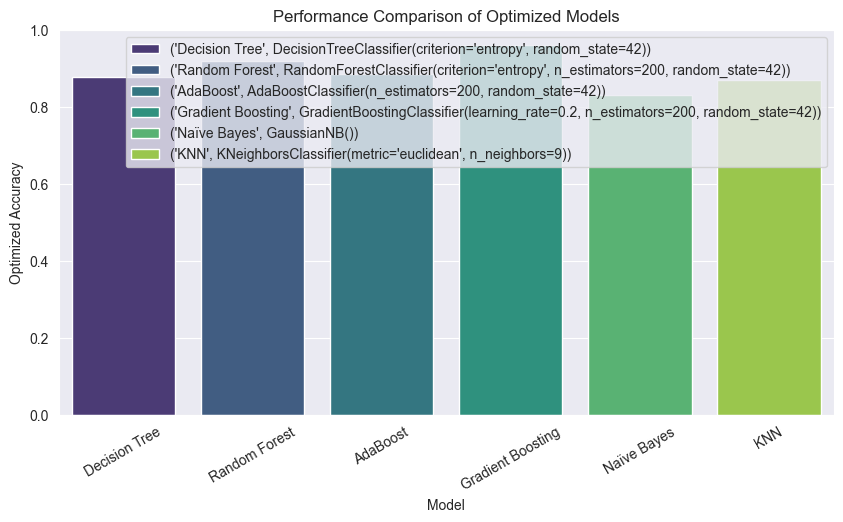

In [56]:
# Collect model accuracies
optimized_accuracies = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in trained_models.items()}

# Plot the accuracies
plt.figure(figsize=(10, 5))
sns.barplot(x=list(optimized_accuracies.keys()), y=list(optimized_accuracies.values()),hue=best_models.items(), palette="viridis")
plt.xlabel("Model")
plt.ylabel("Optimized Accuracy")
plt.title("Performance Comparison of Optimized Models")
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.show()


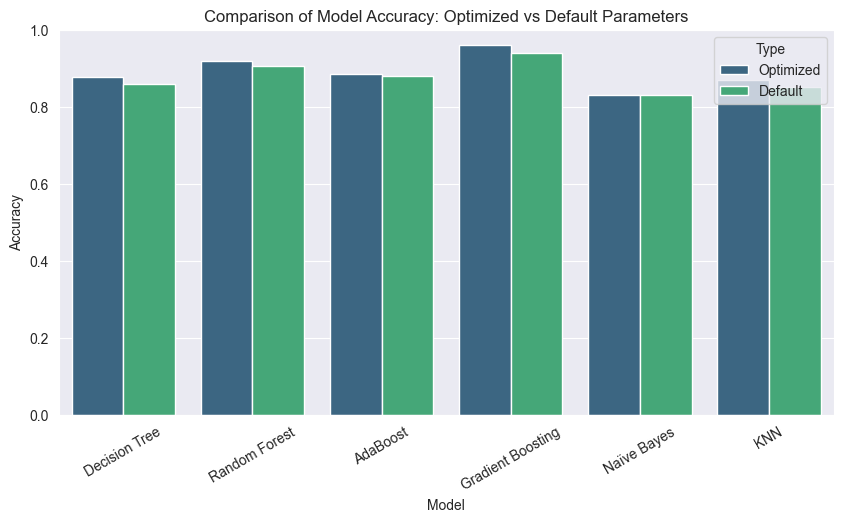

In [57]:
# Initialize dictionaries to store accuracy scores
optimized_accuracies = {}
default_accuracies = {}

# Evaluate optimized models
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    optimized_accuracies[name] = accuracy

# Evaluate default models
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    default_accuracies[name] = accuracy

# Combine results into one dictionary for easier plotting
comparison_accuracies = {
    "Optimized": optimized_accuracies,
    "Default": default_accuracies
}

# Prepare data for plotting
model_names = list(optimized_accuracies.keys())
optimized_scores = list(optimized_accuracies.values())
default_scores = [default_accuracies[name] for name in model_names]

# Create a DataFrame for easier plotting with Seaborn
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": model_names * 2,  # Repeat model names for both optimized and default
    "Accuracy": optimized_scores + default_scores,  # Combine optimized and default accuracies
    "Type": ["Optimized"] * len(model_names) + ["Default"] * len(model_names)  # Add Type label
})

# Plot comparison
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Accuracy", hue="Type", data=comparison_df, palette="viridis")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy: Optimized vs Default Parameters")
plt.xticks(rotation=30)
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.show()


🔹 Decision Tree Evaluation Metrics:
Accuracy: 0.8767
Precision: 0.8765
Recall: 0.8767
F1-Score: 0.8765
ROC-AUC Score: 0.9041054031872436


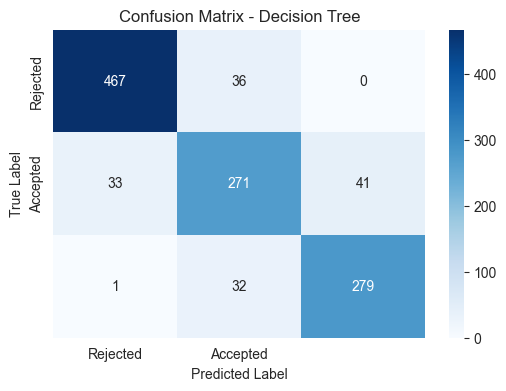


🔹 Random Forest Evaluation Metrics:
Accuracy: 0.9190
Precision: 0.9184
Recall: 0.9190
F1-Score: 0.9183
ROC-AUC Score: 0.9871810507208414


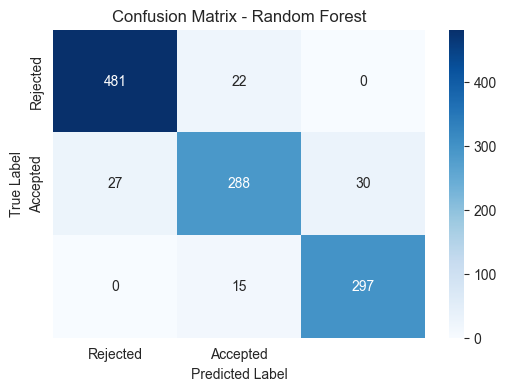


🔹 AdaBoost Evaluation Metrics:
Accuracy: 0.8862
Precision: 0.9037
Recall: 0.8862
F1-Score: 0.8894
ROC-AUC Score: 0.9203968342908135


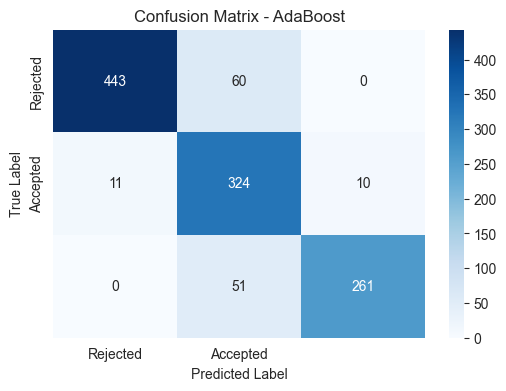


🔹 Gradient Boosting Evaluation Metrics:
Accuracy: 0.9603
Precision: 0.9608
Recall: 0.9603
F1-Score: 0.9605
ROC-AUC Score: 0.9954555456346231


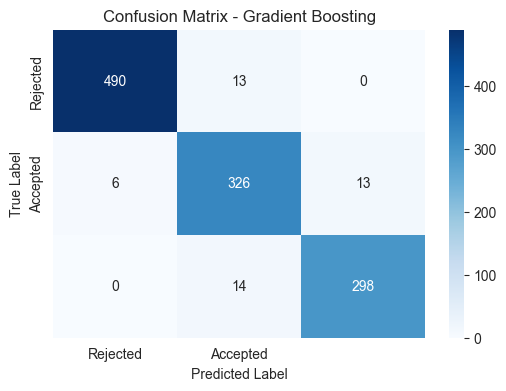


🔹 Naïve Bayes Evaluation Metrics:
Accuracy: 0.8319
Precision: 0.8346
Recall: 0.8319
F1-Score: 0.8329
ROC-AUC Score: 0.9510906386690916


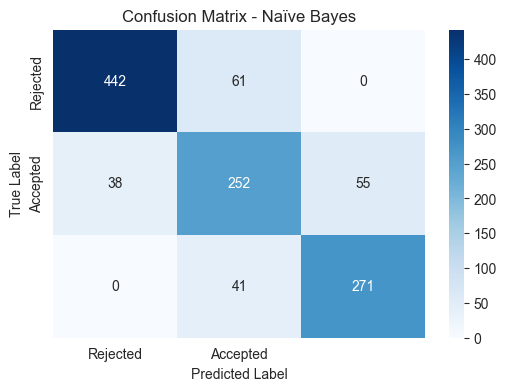


🔹 KNN Evaluation Metrics:
Accuracy: 0.8698
Precision: 0.8707
Recall: 0.8698
F1-Score: 0.8700
ROC-AUC Score: 0.9674156534780041


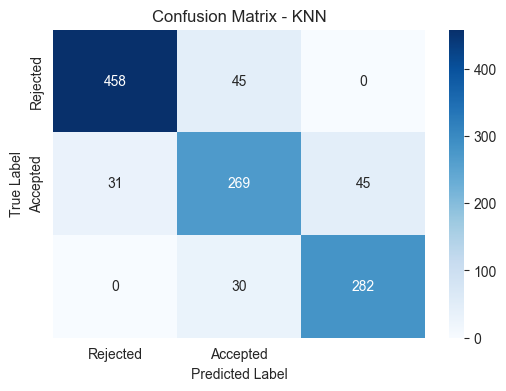


🔹 Model Performance Comparison:

📌 Decision Tree:
  Accuracy: 0.8767
  Precision: 0.8765
  Recall: 0.8767
  F1-Score: 0.8765
  ROC-AUC: 0.9041

📌 Random Forest:
  Accuracy: 0.9190
  Precision: 0.9184
  Recall: 0.9190
  F1-Score: 0.9183
  ROC-AUC: 0.9872

📌 AdaBoost:
  Accuracy: 0.8862
  Precision: 0.9037
  Recall: 0.8862
  F1-Score: 0.8894
  ROC-AUC: 0.9204

📌 Gradient Boosting:
  Accuracy: 0.9603
  Precision: 0.9608
  Recall: 0.9603
  F1-Score: 0.9605
  ROC-AUC: 0.9955

📌 Naïve Bayes:
  Accuracy: 0.8319
  Precision: 0.8346
  Recall: 0.8319
  F1-Score: 0.8329
  ROC-AUC: 0.9511

📌 KNN:
  Accuracy: 0.8698
  Precision: 0.8707
  Recall: 0.8698
  F1-Score: 0.8700
  ROC-AUC: 0.9674


In [58]:
# Function to evaluate models with multiple metrics
def evaluate_model_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  # Probabilities for ROC-AUC

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    # Get probability predictions if available
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') if len(set(y_test)) > 2 else roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        roc_auc = "N/A"

    # Print evaluation results
    print(f"\n🔹 {model_name} Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1-Score": f1, "ROC-AUC": roc_auc}

# Evaluate all trained models
evaluation_results = {}
for name, model in best_models.items():
    evaluation_results[name] = evaluate_model_metrics(model, X_test, y_test, name)

# Print summary of results
print("\n🔹 Model Performance Comparison:")
for model, metrics in evaluation_results.items():
    print(f"\n📌 {model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

In [59]:
# Define K-Fold cross-validation (Stratified for class balance)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross Validation

# Evaluate models using K-Fold
cv_results = {}
for name, model in best_models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    cv_results[name] = scores
    print(f"\n🔹 {name} Cross-Validation Scores: {scores}")
    print(f"Mean Accuracy: {np.mean(scores):.4f}, Standard Deviation: {np.std(scores):.4f}")

# Compare model performance
print("\n📊 Model Performance (K-Fold Cross-Validation):")
for model, scores in cv_results.items():
    print(f"{model}: Mean Accuracy = {np.mean(scores):.4f}")


🔹 Decision Tree Cross-Validation Scores: [0.875      0.87931034 0.8612069  0.86724138 0.89051724]
Mean Accuracy: 0.8747, Standard Deviation: 0.0101

🔹 Random Forest Cross-Validation Scores: [0.89568966 0.90603448 0.90086207 0.91896552 0.91551724]
Mean Accuracy: 0.9074, Standard Deviation: 0.0087

🔹 AdaBoost Cross-Validation Scores: [0.88189655 0.89396552 0.87758621 0.9        0.88448276]
Mean Accuracy: 0.8876, Standard Deviation: 0.0082

🔹 Gradient Boosting Cross-Validation Scores: [0.95258621 0.9637931  0.94482759 0.95689655 0.95689655]
Mean Accuracy: 0.9550, Standard Deviation: 0.0062

🔹 Naïve Bayes Cross-Validation Scores: [0.81551724 0.84224138 0.82672414 0.82844828 0.84224138]
Mean Accuracy: 0.8310, Standard Deviation: 0.0102

🔹 KNN Cross-Validation Scores: [0.86465517 0.86206897 0.85       0.86293103 0.8637931 ]
Mean Accuracy: 0.8607, Standard Deviation: 0.0054

📊 Model Performance (K-Fold Cross-Validation):
Decision Tree: Mean Accuracy = 0.8747
Random Forest: Mean Accuracy = 0.